# hls4ml and oneAPI

This tutorial is based on the hls4ml tutorial notebooks (https://github.com/fastmachinelearning/hls4ml-tutorial/).


## Load the hls4ml jet tagging dataset

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import os
from matplotlib import pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os
import ndjson

2025-04-17 14:27:15.452891: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 14:27:15.490803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 14:27:15.490848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 14:27:15.490871: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 14:27:15.497821: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 14:27:15.498372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
data = fetch_openml('hls4ml_lhc_jets_hlf', as_frame=False, parser='liac-arff')
X, y = data['data'], data['target']

le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


## Create a small model for jet tagging


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1


In [104]:
model = Sequential()
model.add(Dense(32, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 32)                544       
                                                                 
 relu1 (Activation)          (None, 32)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                1056      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 5)                

In [105]:

adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

model.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=10,
    validation_split=0.25,
    shuffle=True,
)


Epoch 1/10
3891/3891 [==============================] - 8s 2ms/step - loss: 1.1002 - accuracy: 0.6138 - val_loss: 0.9022 - val_accuracy: 0.7147
Epoch 2/10
3891/3891 [==============================] - 10s 3ms/step - loss: 0.8604 - accuracy: 0.7222 - val_loss: 0.8420 - val_accuracy: 0.7265
Epoch 3/10
3891/3891 [==============================] - 9s 2ms/step - loss: 0.8266 - accuracy: 0.7293 - val_loss: 0.8212 - val_accuracy: 0.7304
Epoch 4/10
3891/3891 [==============================] - 10s 3ms/step - loss: 0.8092 - accuracy: 0.7330 - val_loss: 0.8064 - val_accuracy: 0.7336
Epoch 5/10
3891/3891 [==============================] - 9s 2ms/step - loss: 0.7965 - accuracy: 0.7359 - val_loss: 0.7958 - val_accuracy: 0.7370
Epoch 6/10
3891/3891 [==============================] - 9s 2ms/step - loss: 0.7869 - accuracy: 0.7385 - val_loss: 0.7866 - val_accuracy: 0.7391
Epoch 7/10
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7791 - accuracy: 0.7406 - val_loss: 0.7798 - val_accurac

In [68]:
y_keras = model.predict(X_test)
keras_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_keras, axis=1))/y_test.shape[0]

print(f"Achieved test accuracy of {(100 * keras_accuracy):.2f}%")

5188/5188 [==============================] - 9s 2ms/step
Achieved test accuracy of 74.93


# Convert the model

Creates a directory with oneAPI code for your model and its weights

## Datatypes in HLS

Fixed point representation is used instead of floating point

For example the hls4ml default `fixed<16,6>` corresponds to:

```
+-------------------------+---------------------------+
|  Integer part (6 bits)  | Fractional part (10 bits) |
+-------------------------+---------------------------+
| 101010                  |                1010101010 |
+-------------------------+---------------------------+
|           Full bitwidth (16 bits)                   |
+-------------------------+---------------------------+
```

Read more:

https://github.com/hlslibs/ac_types/blob/v3.7/pdfdocs/ac_datatypes_ref.pdf


In [71]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='oneAPI', output_dir='model_1/hls4ml_prj', part='Agilex7'
)






Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strate

In [72]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

hls_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]



Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_1/hls4ml_prj/build
[ 33%] Building CXX object CMakeFiles/lib.dir/src/firmware/myproject.cpp.o
[ 66%] Building CXX object CMakeFiles/lib.dir/src/myproject_bridge.cpp.o
[100%] Linking CXX shared library libmyproject-89e53233.so
[100%] Built target lib
Achieved test accuracy of 74.92%


In [73]:
print(f"Achieved test accuracy of {(100 * hls_accuracy):.2f}%")


Achieved test accuracy of 74.92%


## Create a report of the FPGA resource usage

The report is available in the project directory.



In [74]:

hls_model.build(build_type='report')
with open("model_1/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data']
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data']

print(resource_names)
print(available)
print(estimated_resources)

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_1/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.cpp.o

To link manually:
/opt/intel/

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
['ALUTs ', 'FFs  ', 'RAMs ', 'DSPs ', 'MLABs', 'Frac. DSPs']
['974400', '1948800', '7110', '4510', '24360', '0']
{'name': 'Total', 'parent': 'estimatedResources', 'classes': ['summary-highlight', 'nohover'], 'data': [126605, 139081, 8, 16, 18, 5], 'data_percent': [12.993124, 7.1367507, 0.11251758, 0.354767174]}


<div style="background-color:#C2F5DD">


# Exercise

See how changing the bitwidth affects the accuracy as well as resource usage.

Loop over several bitwidths and plot the accuracy and resource usage as a function of bitwidth.

</div>

# Quantization Aware Training

You can achieve similar performance with significantly lower bitwidths by quantizing during training.

This can be achieved with QKeras, which emulates fixed bitwidths during forward pass.



In [95]:
import qkeras
from qkeras import QDense
from qkeras.quantizers import quantized_bits

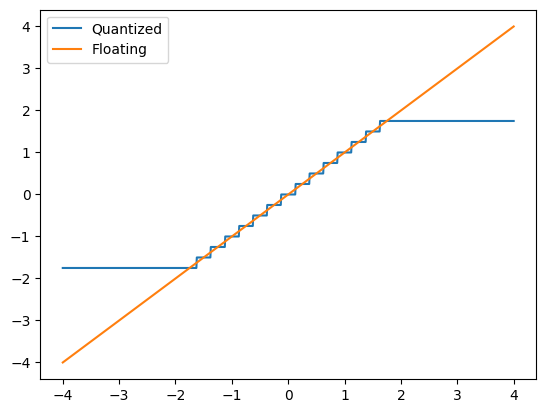

In [88]:
plt.plot(np.linspace(-4,4,1000), quantized_bits(4,1,1,alpha=1)(np.linspace(-4,4,1000)))
plt.plot(np.linspace(-4,4,1000), np.linspace(-4,4,1000))

plt.legend(["Quantized", "Floating"])


## Creating a quantized model

Using the `QDense` layer.

Requires setting `kernel_quantizer` and `bias_quantizer`

In [96]:
qmodel = Sequential()
qmodel.add(QDense(32, input_shape=(16,),
                  name='fc1',
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu1'))
qmodel.add(QDense(32, 
                  name='fc2', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu2'))
qmodel.add(QDense(32, 
                  name='fc3', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu3'))
qmodel.add(QDense(5, 
                  name='output', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='softmax', name='softmax'))

qmodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 32)                544       
                                                                 
 relu1 (Activation)          (None, 32)                0         
                                                                 
 fc2 (QDense)                (None, 32)                1056      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (QDense)                (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (QDense)             (None, 5)                

In [97]:

adam = Adam(learning_rate=0.0001)
qmodel.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

qmodel.set_weights(model.get_weights())

qmodel.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=2,
    validation_split=0.25,
    shuffle=True,
)


Epoch 1/2
3891/3891 [==============================] - 15s 4ms/step - loss: 0.8152 - accuracy: 0.7306 - val_loss: 0.7713 - val_accuracy: 0.7454
Epoch 2/2
3891/3891 [==============================] - 15s 4ms/step - loss: 0.7935 - accuracy: 0.7355 - val_loss: 0.7687 - val_accuracy: 0.7445


In [98]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(qmodel, granularity='name', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel, hls_config=config, backend='oneAPI', output_dir='model_2/hls4ml_prj', part='Agilex7'
)






Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'St

/home/lauri/miniconda3/envs/oneapi-env/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [99]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

hls_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]



Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- The CXX compiler identification is IntelLLVM 2025.0.4
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /opt/intel/oneapi/2025.0/bin/icpx - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.6s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_2/hls4ml_prj/build
[ 33%] Building CXX object CMakeFiles/lib.dir/src/firmware/myproject.cpp.o
[ 66%] Building CXX object CMakeFiles/lib.dir/src/myproject_bridge.cpp.o
[100%] Linking CXX shared library libmyproject-974ccfb0.so
[100%] Built target 

In [100]:
print(f"Achieved test accuracy of {(100 * hls_accuracy):.2f}%")


Achieved test accuracy of 74.31%


In [108]:

hls_model.build(build_type='report')
with open("model_2/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data']
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data']

print(resource_names)
print(available)
print(estimated_resources)

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_2/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.cpp.o

To link manually:
/opt/intel/

Segmentation fault (core dumped)


[100%] Built target report
['ALUTs ', 'FFs  ', 'RAMs ', 'DSPs ', 'MLABs', 'Frac. DSPs']
['974400', '1948800', '7110', '4510', '24360', '0']
[34657, 38922, 8, 0, 23, 5]


<div style="background-color:#C2F5DD">


# Exercise

See how low bitwidth can still have the same accuracy as the baseline model.

Loop over several bitwidths and plot the accuracy and resource usage as a function of bitwidth.

</div>

# Pruning

Weight matrices in NNs can be huge, but not every weight contributes equally to the model performance.

Low magnitude weights can be pruned out with very small impact to the performance.

On FPGAs the weight matrices are known at compile time. Weights that are zero can be omitted by the compiler, which reduces resource usage.

To get sparse weight matrices regularization can be used to reduce weight magnitude and pruning can be then schedules to incrementaly remove and mask low magnitude weights.


In [106]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=100, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

In [107]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

model.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=5,
    validation_split=0.25,
    shuffle=True,
    callbacks=[pruning_callbacks.UpdatePruningStep()],
)


Epoch 1/5
3891/3891 [==============================] - 12s 3ms/step - loss: 0.7687 - accuracy: 0.7402 - val_loss: 0.7458 - val_accuracy: 0.7475
Epoch 2/5
3891/3891 [==============================] - 12s 3ms/step - loss: 0.7353 - accuracy: 0.7494 - val_loss: 0.7324 - val_accuracy: 0.7505
Epoch 3/5
3891/3891 [==============================] - 11s 3ms/step - loss: 0.7242 - accuracy: 0.7522 - val_loss: 0.7234 - val_accuracy: 0.7526
Epoch 4/5
3891/3891 [==============================] - 13s 3ms/step - loss: 0.7148 - accuracy: 0.7547 - val_loss: 0.7151 - val_accuracy: 0.7551
Epoch 5/5
3891/3891 [==============================] - 16s 4ms/step - loss: 0.7089 - accuracy: 0.7563 - val_loss: 0.7101 - val_accuracy: 0.7555


In [112]:
# Strip pruning

model = strip_pruning(model)

In [135]:
for i, l in zip(model.get_weights(), model.layers):
    print(f"{np.sum(i.flatten()==0)/i.flatten().shape[0]*100:.1f}% sparsity for layer {l.name}")

75.0% sparsity for layer fc1
0.0% sparsity for layer relu1
75.0% sparsity for layer fc2
0.0% sparsity for layer relu2
75.0% sparsity for layer fc3
0.0% sparsity for layer relu3
75.0% sparsity for layer output
0.0% sparsity for layer softmax


In [128]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='oneAPI', output_dir='model_3/hls4ml_prj', part='Agilex7'
)






Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strate

In [129]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

hls_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]



Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_1/hls4ml_prj/build
[ 33%] Building CXX object CMakeFiles/lib.dir/src/firmware/myproject.cpp.o
[ 66%] Building CXX object CMakeFiles/lib.dir/src/myproject_bridge.cpp.o
[100%] Linking CXX shared library libmyproject-f833531a.so
[100%] Built target lib


In [130]:
print(f"Achieved test accuracy of {(100 * hls_accuracy):.2f}%")


Achieved test accuracy of 75.50%


In [131]:

hls_model.build(build_type='report')
with open("model_3/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data']
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data']

print(resource_names)
print(available)
print(estimated_resources)

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_1/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.cpp.o

To link manually:
/opt/intel/

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
['ALUTs ', 'FFs  ', 'RAMs ', 'DSPs ', 'MLABs', 'Frac. DSPs']
['974400', '1948800', '7110', '4510', '24360', '0']
[42837, 47838, 8, 5, 19, 5]


<div style="background-color:#C2F5DD">


# Exercise

Train models with different sparsity. Plot the performance and resource usage as function of model sparsity.

How large are the savings in resource usage in comparison to the baseline model before accuracy drops?

</div>

<div style="background-color:#C2F5DD">


# Exercise

Train and synthesize model that uses both quantization aware training and pruning that achieves the same accuracy as the baseline model.

How large are the savings in resource usage in comparison to the baseline model before accuracy drops?

</div>